In [1]:
import warnings
warnings.filterwarnings("ignore")
import findspark
findspark.init()
import random
from pyspark import SparkContext
import pyspark
import numpy as np
sc = SparkContext("local[*]", "Name of the Program")


25/02/25 17:38:44 WARN Utils: Your hostname, jalvarez resolves to a loopback address: 127.0.1.1; using 10.166.129.52 instead (on interface wlo1)
25/02/25 17:38:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/25 17:38:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
def readFile(filename):
    rdd = sc.textFile(filename)
    rdd_numpy = rdd.map(lambda x : np.array(x.split(","), dtype = float))
    rdd_return = rdd_numpy.map(lambda x : (x[:-1], int(x[-1])))
    return rdd_return

def normalize(RDD_Xy):
    
    suma = RDD_Xy.reduce(lambda x,y: (np.array(x[0])+np.array(y[0]),x[1]))
    total_filas = float(RDD_Xy.count())
    media = suma[0] / total_filas

    rdd_2 = RDD_Xy.map(lambda x: (x[0],x[1], media)) 

    restas = rdd_2.map(lambda x: (x[0]-x[2])**2)
    sumas = restas.reduce(lambda x,y: x+y)
    desviacion = (sumas / total_filas)**0.5

    def f(x):
        a = (x[0] - media) / desviacion
        a= np.nan_to_num(a, copy=False,nan=0.0)
        return (a,x[1])

    normalizado = RDD_Xy.map(f)
    return normalizado

def predict(w,b,X,threshold=0.5):
    rdd=X.map(lambda x:np.dot(w,np.array(x[0])+b))
    logistic= rdd.map(lambda x: 1/(1+np.exp(-x)))
    results=logistic.map(lambda x: 1 if x>threshold else 0)
    return results

def get_predictions_targets_inputs(w,b,X,threshold=0.5):
    """
    Get the predictions, targets and inputs
    :param w: weights
    :param b: bias
    :param X: RDD with the data
    :param threshold: threshold to classify the data
    :return: RDD with the tuple predictions, targets and inputs
    """
    rdd=X.map(lambda x:(np.dot(w,np.array(x[0])+b),x[1],x[0]))
    logistic= rdd.map(lambda x: (1/(1+np.exp(-x[0])),x[1],x[2]))
    results=logistic.map(lambda x: ((0.999,x[1],x[2]) if x[0]>threshold else (0.001,x[1],x[2]))) #para evitar log(0)=-inf y log(1)=0
    return results

# TODO preguntar si la b se incluye en la perdida, porque en la formula del enunciado no aparece

def calculate_loss_function(predictions_and_targets,lambda_reg,w):   
    """
    Calculate the loss function for logistic regression
    :param predictions_and_targets: RDD with the predictions and the targets
    :param lambda_reg: regularization parameter
    :param w: weights
    :return: loss function
    """
    def f(x):
        return (-x[1]*np.log(x[0])-(1-x[1])*np.log(1-x[0]))

    loss=predictions_and_targets.map(f)
    suma=loss.reduce(lambda x,y: x+y)/predictions_and_targets.count()
    squared_w=np.dot(w,w)
    squared_w=squared_w*lambda_reg/(2*len(w))
    return suma+squared_w



def train(RDD_Xy, iterations, learning_rate, lambda_reg):
    w = np.random.rand(11)
    b = np.random.rand(1)
    
    for iteration in range(iterations):
        predictions_targets_inputs = get_predictions_targets_inputs(w, b, RDD_Xy)
        
        count = predictions_targets_inputs.count()
        
        gradients = predictions_targets_inputs.map(lambda x: ((x[0] - x[1]) * np.array(x[2]), x[0] - x[1]))
        
        gradient_w = gradients.map(lambda x: x[0]).reduce(lambda x, y: x + y) / count + (lambda_reg * w) / len(w)
        gradient_b = gradients.map(lambda x: x[1]).reduce(lambda x, y: x + y) / count
        
        w -= learning_rate * gradient_w
        b -= learning_rate * gradient_b
        
        loss = calculate_loss_function(predictions_targets_inputs, lambda_reg, w)
        print(f"Iteration: {iteration}, Loss: {loss}")
    
    return w, b

def accuracy(w,b,RDD_Xy):
    predictions_and_targets=get_predictions_targets_inputs(w,b,RDD_Xy)
    correct=predictions_and_targets.map(lambda x: 1 if round(x[0])==x[1] else 0)
    correct=correct.reduce(lambda x,y: x+y)
    return correct/predictions_and_targets.count()

def transform(data,num_blocks_cv):
    data = data.map(lambda x: (random.randint(0, num_blocks_cv-1), x[0],x[1]))
    return data

def get_block_data(data_cv: pyspark.rdd.RDD, i):
    train_data = data_cv.flatMap(lambda x: [(x[1],x[2])] if x[0] != i else [])
    test_data = data_cv.flatMap(lambda x: [(x[1],x[2])] if x[0] == i else [])
    return train_data, test_data


## **EJERCICIO 1**

In [3]:
n = readFile('data/botnet_reduced_10k_l.csv')

normalizado = normalize(n)

w,b=train(normalizado,10,1.5,0)

acc=accuracy(w,b,normalizado)
print(f"Final accuracy: {acc}")

Iteration: 0, Loss: 2.2823016037210886
Iteration: 1, Loss: 1.1758394881816476
Iteration: 2, Loss: 0.7676502807636074
Iteration: 3, Loss: 0.6274431587570193
Iteration: 4, Loss: 0.5777145243507374
Iteration: 5, Loss: 0.537655346634568
Iteration: 6, Loss: 0.5134817049092939
Iteration: 7, Loss: 0.48516401031682527
Iteration: 8, Loss: 0.47273185171525195
Iteration: 9, Loss: 0.46375307050300674
Final accuracy: 0.933


## **EJERCICIO 2**

In [4]:
num_blocks_cv=10
rdd_with_keys = transform(normalizado, num_blocks_cv)
rdd_with_keys.cache()
all_ac=[]
for i in range(num_blocks_cv):
    train_data, test_data = get_block_data(rdd_with_keys, i)
    print("-"*50)
    print(f"Block {i}")
    w,b=train(train_data,10,1.5,0)
    acc=accuracy(w,b,test_data)
    all_ac.append(acc)
    print(f"Accuracy: {acc}")


--------------------------------------------------
Block 0
Iteration: 0, Loss: 2.4598052015323684
Iteration: 1, Loss: 1.0224327903759496
Iteration: 2, Loss: 0.7853008763090366
Iteration: 3, Loss: 0.6371893571668796
Iteration: 4, Loss: 0.547401545044424
Iteration: 5, Loss: 0.5005890959891278
Iteration: 6, Loss: 0.47065982528164146
Iteration: 7, Loss: 0.46068340171247896
Iteration: 8, Loss: 0.4514743953409489
Iteration: 9, Loss: 0.44917214374806635
Accuracy: 0.933
--------------------------------------------------
Block 1
Iteration: 0, Loss: 1.9843799696931639
Iteration: 1, Loss: 0.9406583212234113
Iteration: 2, Loss: 0.6893634486966688
Iteration: 3, Loss: 0.6169041909742254
Iteration: 4, Loss: 0.5745078167749229
Iteration: 5, Loss: 0.5475283059208191
Iteration: 6, Loss: 0.5035902453869907
Iteration: 7, Loss: 0.4804649503691873
Iteration: 8, Loss: 0.4696731460275451
Iteration: 9, Loss: 0.4550271258496056
Accuracy: 0.9240384615384616
--------------------------------------------------
Bloc

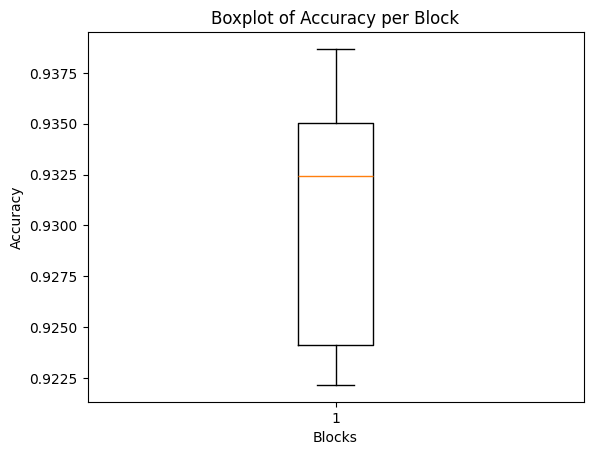

In [10]:
import matplotlib.pyplot as plt
plt.boxplot(all_ac)
plt.xlabel('Blocks')
plt.ylabel('Accuracy')
plt.title('Boxplot of Accuracy per Block')
plt.show()
plt.bar(range(num_blocks_cv), all_ac)
plt.xlabel('Block')
plt.ylabel('Accuracy')
plt.title('Accuracy per Block')
plt.show()

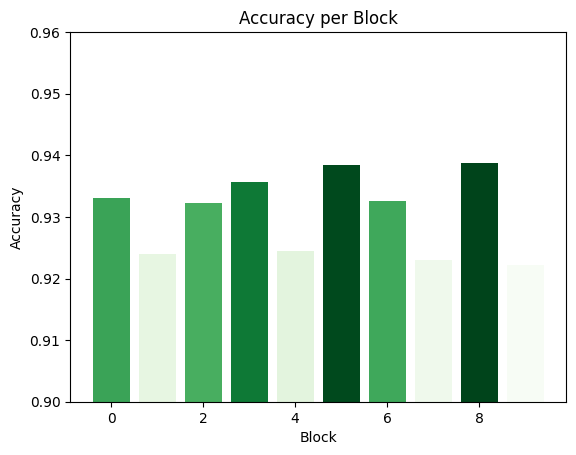

In [29]:
colors = plt.cm.Greens((np.array(all_ac) - min(all_ac)) / (max(all_ac) - min(all_ac)))
plt.bar(range(num_blocks_cv), all_ac, color=colors)
plt.xlabel('Block')
plt.ylabel('Accuracy')
plt.title('Accuracy per Block')
plt.ylim(0.90, 0.96)
plt.show()
